In [1]:
import pandas as pd
import numpy as np
#import tensorflow.compat.v1 as tf
import tensorflow as tf
from tqdm import tqdm
from utils import *
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
## imputations
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Needed to import IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
import fancyimpute
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
#from midaspy import MIDAS

In [2]:
### loading the dataset
heart_df = pd.read_csv("heart.csv")

In [3]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
##### can add data visualisation but I dont think so it is required
##### feature importance can be added though
dataset_copy = heart_df.copy()
dataset_DL = heart_df.copy()

In [ ]:
#dataset['col_HeartDisease'] = dataset['HeartDisease'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [ ]:
#dataset = dataset.drop(columns = 'HeartDisease', axis = 1)
#dataset["HeartDisease"] = dataset["col_HeartDisease"]
#dataset = dataset.drop(columns = 'col_HeartDisease', axis = 1)

In [5]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
X = heart_df.drop("HeartDisease", axis = 1)
y = heart_df["HeartDisease"]

In [7]:
### using label encoder to convert categorical data to numeric data using label encoding
cols=  ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
label_encoders = {}

for i in cols:
    le = LabelEncoder()
    X[i] = le.fit_transform(X[i])
    label_encoders[i] = le

In [8]:
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 42)

In [ ]:
#cols = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]
#for i in cols:
#    sc = StandardScaler()
#    X_train[i] = sc.fit_transform(X_train[i].values.reshape(-1,1))
#    X_test[i] = sc.transform(X_test[i].values.reshape(-1,1))

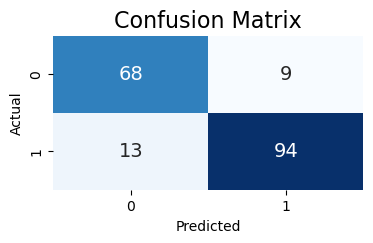

In [10]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [11]:
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8804
Precision: 0.9126
Recall: 0.8785
F1 Score: 0.8952

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [12]:
accuracy

0.8804347826086957

## creating missing values - MNAR

In [13]:
## creating a copy of the dataset
data = X.copy()
target = y.copy()

In [15]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" , proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [16]:
def MNAR_mask_logistic(X, p, p_params =.3, exclude_inputs=True):
    """
    Missing not at random mechanism with a logistic masking model. It implements two mechanisms:
    (i) Missing probabilities are selected with a logistic model, taking all variables as inputs. Hence, values that are
    inputs can also be missing.
    (ii) Variables are split into a set of intputs for a logistic model, and a set whose missing probabilities are
    determined by the logistic model. Then inputs are then masked MCAR (hence, missing values from the second set will
    depend on masked values.
    In either case, weights are random and the intercept is selected to attain the desired proportion of missing values.

    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.

    p : float
        Proportion of missing values to generate for variables which will have missing values.

    p_params : float
        Proportion of variables that will be used for the logistic masking model (only if exclude_inputs).

    exclude_inputs : boolean, default=True
        True: mechanism (ii) is used, False: (i)

    Returns
    -------
    mask : torch.BoolTensor or np.ndarray (depending on type of X)
        Mask of generated missing values (True if the value is missing).

    """

    n, d = X.shape

    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = torch.from_numpy(X)

    mask = torch.zeros(n, d).bool() if to_torch else np.zeros((n, d)).astype(bool)

    d_params = max(int(p_params * d), 1) if exclude_inputs else d ## number of variables used as inputs (at least 1)
    d_na = d - d_params if exclude_inputs else d ## number of variables masked with the logistic model

    ### Sample variables that will be parameters for the logistic regression:
    idxs_params = np.random.choice(d, d_params, replace=False) if exclude_inputs else np.arange(d)
    idxs_nas = np.array([i for i in range(d) if i not in idxs_params]) if exclude_inputs else np.arange(d)

    ### Other variables will have NA proportions selected by a logistic model
    ### The parameters of this logistic model are random.

    ### Pick coefficients so that W^Tx has unit variance (avoids shrinking)
    coeffs = pick_coeffs(X, idxs_params, idxs_nas)
    ### Pick the intercepts to have a desired amount of missing values
    intercepts = fit_intercepts(X[:, idxs_params], coeffs, p)

    ps = torch.sigmoid(X[:, idxs_params].mm(coeffs) + intercepts)

    ber = torch.rand(n, d_na)
    mask[:, idxs_nas] = ber < ps

    ## If the inputs of the logistic model are excluded from MNAR missingness,
    ## mask some values used in the logistic model at random.
    ## This makes the missingness of other variables potentially dependent on masked values

    if exclude_inputs:
        mask[:, idxs_params] = torch.rand(n, d_params) < p

    return mask

In [ ]:
"""Missing Completely At Random values are generated using only the desired proportion of missing values p_miss, i.e.
each value have the same probability p_miss of being missing. Therefore, we generate missing values using a
Bernoulli distribution of parameter p_miss"""

In [ ]:
"""the above function gives 3 outputs, i.e., X_init, X_incomp, and mask, all in form of numpy arrays
X_init => the initial data matrix
X_incomp => the data with the generated missing values
mask => array, that does the masking to create missing values."""

In [19]:
# Convert DataFrame to NumPy array
data_array = data.to_numpy()

# Now call the function with the NumPy array
data_MNAR = produce_NA(data_array, p_miss=0.25, mecha="MNAR", opt="logistic", p_obs=0.5)

# If you need to convert it back to a DataFrame after processing
data_MNAR_df = pd.DataFrame(data_MNAR['X_incomp'], columns=data.columns)

In [20]:
data_MNAR_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,1.0,1.0,NaN,289.0,0.0,NaN,172.0,NaN,0.0,2.0
1,49.0,0.0,2.0,NaN,180.0,0.0,1.0,156.0,0.0,NaN,1.0
2,NaN,1.0,1.0,130.0,283.0,0.0,NaN,98.0,NaN,0.0,2.0
3,48.0,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0
4,54.0,1.0,2.0,150.0,NaN,0.0,1.0,122.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
913,45.0,NaN,NaN,110.0,NaN,0.0,1.0,NaN,0.0,1.2,1.0
914,68.0,1.0,NaN,144.0,193.0,1.0,NaN,NaN,NaN,3.4,1.0
915,57.0,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.2,1.0
916,57.0,0.0,1.0,NaN,236.0,0.0,0.0,174.0,0.0,0.0,1.0


In [21]:
data.shape

(918, 11)

In [22]:
data_MNAR_df.isna().sum()

Age               243
Sex               226
ChestPainType     221
RestingBP         233
Cholesterol       250
FastingBS         244
RestingECG        238
MaxHR             236
ExerciseAngina    207
Oldpeak           248
ST_Slope          235
dtype: int64

Text(0.5, 1.0, 'Missing Data Patterns (Original)')

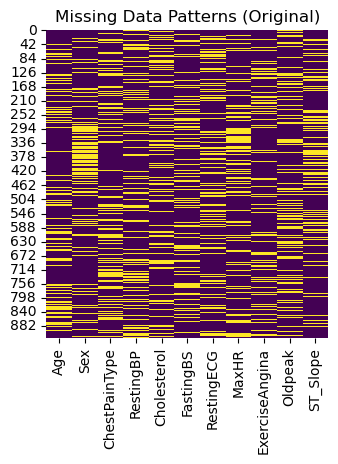

In [23]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(data_MNAR_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Patterns (Original)')

In [24]:
print("Percentage of newly generated missing values: ", (data_MNAR['mask'].sum()).numpy()/np.prod(data_MNAR['mask'].size())*100, " %")

Percentage of newly generated missing values:  25.559516735987327  %


In [25]:
## using inverse lable encoding for DL methods
data_MNAR_DL = data_MNAR_df.copy()

In [26]:
for col in cols:
    le = label_encoders[col]  # Retrieve the stored LabelEncoder
    
    # Create a mask for NaN values
    nan_mask = data_MNAR_DL[col].isna()
    
    # Create a temporary column with NaNs preserved
    temp_col = data_MNAR_DL[col].copy()
    
    # Perform inverse transform on non-NaN values
    temp_col[~nan_mask] = le.inverse_transform(temp_col[~nan_mask].astype(int))
    
    # Restore NaN values
    temp_col[nan_mask] = np.nan
    
    data_MNAR_DL[col] = temp_col

In [27]:
data_MNAR_DL.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,M,ATA,NaN,289.0,0.0,NaN,172.0,NaN,0.0,Up
1,49.0,F,NAP,NaN,180.0,0.0,Normal,156.0,N,NaN,Flat
2,NaN,M,ATA,130.0,283.0,0.0,NaN,98.0,NaN,0.0,Up
3,48.0,F,ASY,138.0,214.0,0.0,Normal,108.0,Y,1.5,Flat
4,54.0,M,NAP,150.0,NaN,0.0,Normal,122.0,N,0.0,Up


In [28]:
data_MNAR_DL.isna().sum()

Age               243
Sex               226
ChestPainType     221
RestingBP         233
Cholesterol       250
FastingBS         244
RestingECG        238
MaxHR             236
ExerciseAngina    207
Oldpeak           248
ST_Slope          235
dtype: int64

# Simple Imputation

In [29]:
data_MNAR_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,1.0,1.0,NaN,289.0,0.0,NaN,172.0,NaN,0.0,2.0
1,49.0,0.0,2.0,NaN,180.0,0.0,1.0,156.0,0.0,NaN,1.0
2,NaN,1.0,1.0,130.0,283.0,0.0,NaN,98.0,NaN,0.0,2.0
3,48.0,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0
4,54.0,1.0,2.0,150.0,NaN,0.0,1.0,122.0,0.0,0.0,2.0


In [30]:
# using mean and mode imputation as a mixed strategy
# mean -> Age, restingBP, cholestrol, fastingBS, MaxHR, oldPeak, HeartDisease
# median -> 
# mode -> sex, RestingECG, ExerciseAngina, ST_Slope
data_MNAR_simple_imput = data_MNAR_df.copy()

In [31]:
mean_columns = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
column_mean = data_MNAR_simple_imput[mean_columns].mean()

In [32]:
column_mean

Age             53.786667
RestingBP      132.988321
Cholesterol    195.848802
FastingBS        0.228487
MaxHR          137.895894
Oldpeak          0.872687
dtype: float64

In [33]:
mode_columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
column_mode = data_MNAR_simple_imput[mode_columns].mode().iloc[0] 
## because .mode() function returns a dataframe while we need only it as pandas data series.

In [34]:
column_mode

Sex               1.0
ChestPainType     0.0
RestingECG        1.0
ExerciseAngina    0.0
ST_Slope          1.0
Name: 0, dtype: float64

In [35]:
data_MNAR_simple_imput[mean_columns] = data_MNAR_simple_imput[mean_columns].fillna(column_mean)
data_MNAR_simple_imput[mode_columns] = data_MNAR_simple_imput[mode_columns].fillna(column_mode)

In [36]:
data_MNAR_simple_imput.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.000000,1.0,1.0,132.988321,289.000000,0.0,1.0,172.0,0.0,0.000000,2.0
1,49.000000,0.0,2.0,132.988321,180.000000,0.0,1.0,156.0,0.0,0.872687,1.0
2,53.786667,1.0,1.0,130.000000,283.000000,0.0,1.0,98.0,0.0,0.000000,2.0
3,48.000000,0.0,0.0,138.000000,214.000000,0.0,1.0,108.0,1.0,1.500000,1.0
4,54.000000,1.0,2.0,150.000000,195.848802,0.0,1.0,122.0,0.0,0.000000,2.0


In [37]:
X = data_MNAR_simple_imput
y = target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 42)

In [39]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
795,53.786667,1.0,2.0,120.0,195.848802,1.0,1.0,194.0,0.0,0.8,0.0
25,53.786667,1.0,2.0,130.0,209.000000,0.0,1.0,178.0,0.0,0.0,1.0
84,56.000000,1.0,0.0,150.0,213.000000,1.0,1.0,125.0,1.0,1.0,1.0
10,37.000000,0.0,2.0,130.0,211.000000,0.0,1.0,142.0,0.0,0.0,2.0
344,51.000000,1.0,0.0,120.0,0.000000,1.0,1.0,104.0,0.0,0.0,1.0


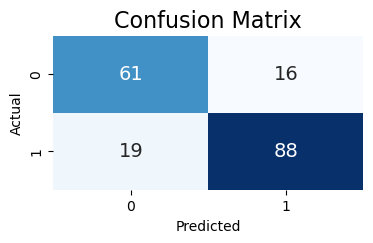

In [40]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
cf_matrix_simple_impute = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_simple_impute, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_simple_impute = accuracy_score(y_test,y_pred)
precision_simple_impute = precision_score(y_test, y_pred)
recall_simple_impute = recall_score(y_test, y_pred)
f1_simple_impute = f1_score(y_test, y_pred)

In [41]:
print(f'Accuracy: {accuracy_simple_impute:.4f}')
print(f'Precision: {precision_simple_impute:.4f}')
print(f'Recall: {recall_simple_impute:.4f}')
print(f'F1 Score: {f1_simple_impute:.4f}')

Accuracy: 0.8098
Precision: 0.8462
Recall: 0.8224
F1 Score: 0.8341


# KNN

In [ ]:
## KNN imputation
## not using target variable for imputation 

In [42]:
data_MNAR_knn = data_MNAR_df.copy()

In [43]:
data_MNAR_knn.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,1.0,1.0,NaN,289.0,0.0,NaN,172.0,NaN,0.0,2.0
1,49.0,0.0,2.0,NaN,180.0,0.0,1.0,156.0,0.0,NaN,1.0
2,NaN,1.0,1.0,130.0,283.0,0.0,NaN,98.0,NaN,0.0,2.0
3,48.0,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0
4,54.0,1.0,2.0,150.0,NaN,0.0,1.0,122.0,0.0,0.0,2.0


In [44]:
data_MNAR_knn.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [45]:
data_MNAR_knn.isna().sum()

Age               243
Sex               226
ChestPainType     221
RestingBP         233
Cholesterol       250
FastingBS         244
RestingECG        238
MaxHR             236
ExerciseAngina    207
Oldpeak           248
ST_Slope          235
dtype: int64

In [46]:

# Define a function to evaluate different k values
def evaluate_knn_imputation(k_values, X, y):
    results = {}
    for k in k_values:
        knn_imputer = KNNImputer(n_neighbors=k)
        X_imputed = knn_imputer.fit_transform(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=1)
        
        # Train and evaluate a model (e.g., Random Forest) on the imputed data
        rf_clf = RandomForestClassifier(random_state=42)
        rf_clf.fit(X_train, y_train)
        
        # Evaluate the model using cross-validation
        scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
        results[k] = scores.mean()
    return results

# Evaluate different k values
k_values = range(1, 21)
results = evaluate_knn_imputation(k_values, data_MNAR_knn, y)

# Find the best k value
best_k = max(results, key=results.get)
print(f'Best k value: {best_k} with accuracy: {results[best_k]}')

Best k value: 17 with accuracy: 0.82971764048085


In [47]:
results

{1: 0.787466219364458,
 2: 0.807920976609822,
 3: 0.8133631534805703,
 4: 0.8161121983039792,
 5: 0.8215357375827044,
 6: 0.8106327462491846,
 7: 0.8187960115553071,
 8: 0.825608051439754,
 9: 0.8201658745690057,
 10: 0.8283477774671513,
 11: 0.8269779144534526,
 12: 0.8079396142018451,
 13: 0.8283384586711395,
 14: 0.8269965520454757,
 15: 0.8269872332494641,
 16: 0.8269872332494641,
 17: 0.82971764048085,
 18: 0.8296990028888267,
 19: 0.8229149193924146,
 20: 0.8215543751747274}

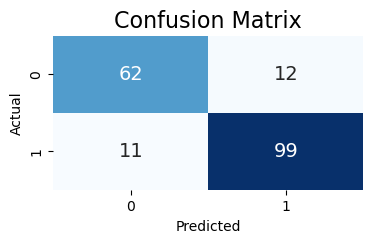

In [48]:
knn_imputer = KNNImputer(n_neighbors=best_k)
X_imputed_best = knn_imputer.fit_transform(data_MNAR_knn)

# Split the data using the imputed dataset with the best k
X_train, X_test, y_train, y_test = train_test_split(X_imputed_best, y, test_size=0.2, random_state=1)

# Train the model (Random Forest) on the imputed data
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cf_matrix_knn_impute = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_knn_impute, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_knn_impute = accuracy_score(y_test,y_pred)
precision_knn_impute = precision_score(y_test, y_pred)
recall_knn_impute = recall_score(y_test, y_pred)
f1_knn_impute = f1_score(y_test, y_pred)


In [49]:
print(f'Accuracy: {accuracy_knn_impute:.4f}')
print(f'Precision: {precision_knn_impute:.4f}')
print(f'Recall: {recall_knn_impute:.4f}')
print(f'F1 Score: {f1_knn_impute:.4f}')

Accuracy: 0.8750
Precision: 0.8919
Recall: 0.9000
F1 Score: 0.8959


# MICE

In [50]:
## MICE imputation
data_MNAR_mice = data_MNAR_df.copy()
data_MNAR_mice.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,1.0,1.0,NaN,289.0,0.0,NaN,172.0,NaN,0.0,2.0
1,49.0,0.0,2.0,NaN,180.0,0.0,1.0,156.0,0.0,NaN,1.0
2,NaN,1.0,1.0,130.0,283.0,0.0,NaN,98.0,NaN,0.0,2.0
3,48.0,0.0,0.0,138.0,214.0,0.0,1.0,108.0,1.0,1.5,1.0
4,54.0,1.0,2.0,150.0,NaN,0.0,1.0,122.0,0.0,0.0,2.0


In [51]:
def evaluate_mice_imputation(max_iter_values, X, y):
    results_mice = {}
    for max_iter in max_iter_values:
        # Initialize the MICE imputer with different max_iter values
        mice_imputer = IterativeImputer(max_iter=max_iter, random_state=42)
        X_imputed = mice_imputer.fit_transform(X)
        
        # Split the imputed data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=1)
        
        # Train and evaluate a model (e.g., Random Forest) on the imputed data
        rf_clf = RandomForestClassifier(random_state=42)
        rf_clf.fit(X_train, y_train)
        
        # Evaluate the model using cross-validation
        scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
        results_mice[max_iter] = scores.mean()
    
    return results_mice

# List of max_iter values to evaluate
max_iter_values = range(1, 21)

# Call the function to evaluate different max_iter values
results_mice = evaluate_mice_imputation(max_iter_values, data_MNAR_mice, y)

best_max_iter = max(results_mice, key=results.get)
print(f'Best iter value: {best_max_iter} with accuracy: {results_mice[best_max_iter]}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_it

Best iter value: 17 with accuracy: 0.81881464914733


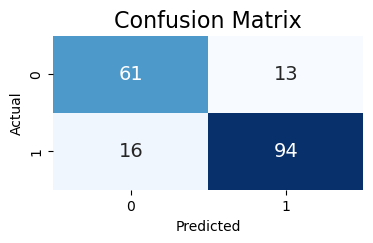

In [52]:
mice_imputer = IterativeImputer(max_iter=best_max_iter, random_state=42)
X_imputed_best = mice_imputer.fit_transform(data_MNAR_mice)

# Split the data using the imputed dataset with the best max_iter
X_train, X_test, y_train, y_test = train_test_split(X_imputed_best, y, test_size=0.2, random_state=1)

# Train the model on the imputed data
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

cf_matrix_mice_impute = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_mice_impute, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_mice_impute = accuracy_score(y_test,y_pred)
precision_mice_impute = precision_score(y_test, y_pred)
recall_mice_impute = recall_score(y_test, y_pred)
f1_mice_impute = f1_score(y_test, y_pred)

In [53]:
print(f'Accuracy: {accuracy_mice_impute:.4f}')
print(f'Precision: {precision_mice_impute:.4f}')
print(f'Recall: {recall_mice_impute:.4f}')
print(f'F1 Score: {f1_mice_impute:.4f}')

Accuracy: 0.8424
Precision: 0.8785
Recall: 0.8545
F1 Score: 0.8664


# Expectation - Maximization

In [54]:
data_MNAR_EM = data_MNAR_df.copy()

In [55]:
missing_mask = np.isnan(data_MNAR_EM)
print(missing_mask)

       Age    Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0    False  False          False       True        False      False   
1    False  False          False       True        False      False   
2     True  False          False      False        False      False   
3    False  False          False      False        False      False   
4    False  False          False      False         True      False   
..     ...    ...            ...        ...          ...        ...   
913  False   True           True      False         True      False   
914  False  False           True      False        False      False   
915  False  False          False      False        False      False   
916  False  False          False       True        False      False   
917  False  False          False      False        False      False   

     RestingECG  MaxHR  ExerciseAngina  Oldpeak  ST_Slope  
0          True  False            True    False     False  
1         False  False     

In [56]:
# Initialize GMM
n_components = 2  # Assuming we want 2 Gaussian components
gmm = GaussianMixture(n_components=n_components, random_state=0)

In [57]:
# Fit the GMM to the data with missing values
# Masked data is not directly supported by GMM, so use an imputer to fill missing values first
imputer = SimpleImputer(strategy='mean')
## this can also be done by dropping the missing rows.
X_imputed = imputer.fit_transform(X)

In [58]:
gmm.fit(X_imputed)

GaussianMixture(n_components=2, random_state=0)

In [59]:
def impute_missing_values(X, gmm):
    # Ensure X is a NumPy array
    X_complete = X.values if isinstance(X, pd.DataFrame) else X.copy()
    #X_complete = X.copy()
    missing_indices = np.isnan(X_complete)

    # Predict missing values
    for feature in range(X_complete.shape[1]):
        if np.any(missing_indices[:, feature]):
            # Mask for missing values in the current feature
            mask = missing_indices[:, feature]
            # Predict using the GMM
            sampled_values, _ = gmm.sample(sum(mask))
            X_complete[mask, feature] = sampled_values[:, feature]

    return X_complete

# Ensure that X_scaled is a NumPy array before calling the function
X_imputed = impute_missing_values(X, gmm)

In [60]:
imputed_data = pd.DataFrame(X_imputed, columns=X.columns)

In [61]:
imputed_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.000000,1.0,1.0,132.988321,289.000000,0.0,1.0,172.0,0.0,0.000000,2.0
1,49.000000,0.0,2.0,132.988321,180.000000,0.0,1.0,156.0,0.0,0.872687,1.0
2,53.786667,1.0,1.0,130.000000,283.000000,0.0,1.0,98.0,0.0,0.000000,2.0
3,48.000000,0.0,0.0,138.000000,214.000000,0.0,1.0,108.0,1.0,1.500000,1.0
4,54.000000,1.0,2.0,150.000000,195.848802,0.0,1.0,122.0,0.0,0.000000,2.0


In [62]:
imputed_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

In [63]:
X = imputed_data
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 42)

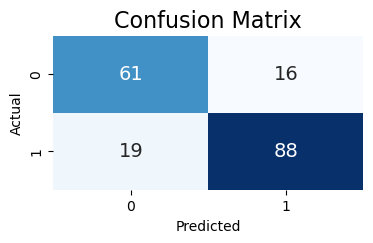

In [64]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cf_matrix_EM = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_EM, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_EM = accuracy_score(y_test,y_pred)
precision_EM = precision_score(y_test, y_pred)
recall_EM = recall_score(y_test, y_pred)
f1_EM = f1_score(y_test, y_pred)

In [65]:
print(f'Accuracy: {accuracy_EM:.4f}')
print(f'Precision: {precision_EM:.4f}')
print(f'Recall: {recall_EM:.4f}')
print(f'F1 Score: {f1_EM:.4f}')

Accuracy: 0.8098
Precision: 0.8462
Recall: 0.8224
F1 Score: 0.8341


# Deep learning approach

## GAIN

In [66]:
# Necessary packages

def normalization(data):
    '''Normalize data in [0, 1] range.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

    # Parameters
    _, dim = data.shape
    norm_data = data.copy()

    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)

    # For each dimension
    for i in range(dim):
        min_val[i] = np.nanmin(norm_data[:, i])
        norm_data[:, i] = norm_data[:, i] - np.nanmin(norm_data[:, i])
        max_val[i] = np.nanmax(norm_data[:, i])
        norm_data[:, i] = norm_data[:, i] / (np.nanmax(norm_data[:, i]) + 1e-6)

        # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}

    return norm_data, norm_parameters


def renormalization(norm_data, norm_parameters):
    '''Renormalize data from [0, 1] range to the original range.
  
  Args:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  
  Returns:
    - renorm_data: renormalized original data
  '''

    min_val = norm_parameters['min_val']
    max_val = norm_parameters['max_val']

    _, dim = norm_data.shape
    renorm_data = norm_data.copy()

    for i in range(dim):
        renorm_data[:, i] = renorm_data[:, i] * (max_val[i] + 1e-6)
        renorm_data[:, i] = renorm_data[:, i] + min_val[i]

    return renorm_data


def rounding(imputed_data, data_x):
    '''Round imputed data for categorical variables.
  
  Args:
    - imputed_data: imputed data
    - data_x: original data with missing values
    
  Returns:
    - rounded_data: rounded imputed data
  '''

    _, dim = data_x.shape
    rounded_data = imputed_data.copy()

    for i in range(dim):
        temp = data_x[~np.isnan(data_x[:, i]), i]
        # Only for the categorical variable
        if len(np.unique(temp)) < 10:
            rounded_data[:, i] = np.round(rounded_data[:, i])

    return rounded_data


def rmse_loss(ori_data, imputed_data, data_m):
    '''Compute RMSE loss between ori_data and imputed_data
  
  Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
  Returns:
    - rmse: Root Mean Squared Error
  '''

    ori_data, _ = normalization(ori_data)
    imputed_data, _ = normalization(imputed_data)

    # Only for missing values
    nominator = np.sum(((1 - data_m) * ori_data - (1 - data_m) * imputed_data) ** 2)
    denominator = np.sum(1 - data_m)

    rmse = np.sqrt(nominator / float(denominator))

    return rmse


def xavier_init(size):
    '''Xavier initialization.
  
  Args:
    - size: vector size
    
  Returns:
    - initialized random vector.
  '''
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


def binary_sampler(p, rows, cols):
    '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
    unif_random_matrix = np.random.uniform(0., 1., size=[rows, cols])
    binary_random_matrix = 1 * (unif_random_matrix < p)
    return binary_random_matrix.astype('float32')


def uniform_sampler(low, high, rows, cols):
    '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
    return np.random.uniform(low, high, size=[rows, cols]).astype('float32')


def uniform_categorical_sampler(n_classes, rows):
    return np.array([np.random.choice(n, rows) for n in n_classes]).T

def sample_batch_index(total, batch_size):
    '''Sample index of the mini-batch.
  
  Args:
    - total: total number of samples
    - batch_size: batch size
    
  Returns:
    - batch_idx: batch index
  '''
    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

def initial_imputation(data_raw, cat_index, num_index):
    data = data_raw.copy()
    # replace nan in categorical variable by the most frequent value
    if cat_index:
        common_value = np.apply_along_axis(lambda x: np.bincount(x[~np.isnan(x)].astype(np.int64)).argmax(), 0,
                                           data[:, cat_index])
        for j in range(len(cat_index)):
            data[np.isnan(data[:, cat_index[j]]), cat_index[j]] = common_value[j]
    # replace nan in numerical variable by its mean
    if num_index:
        mean_value = np.nanmean(data[:, num_index], axis=0)
        for j in range(len(num_index)):
            data[np.isnan(data[:, num_index[j]]), num_index[j]] = mean_value[j]
    return data

def onehot_encoding(data, data_m, all_levels, has_miss=False):
    no, dim = data.shape

    data_filled = np.nan_to_num(data.copy(), 0)
    data_enc = np.empty(shape=(no, np.sum([len(x) for x in all_levels])), dtype=np.float32)
    data_m_enc = np.empty(shape=(no, np.sum([len(x) for x in all_levels])), dtype=np.float32)
    col_idx = 0
    for j in range(dim):
        colj_nlevel = len(all_levels[j])
        colj = data_filled[:, j].astype(np.int64)
        miss_j = np.repeat(data_m[:, j].reshape([-1, 1]), colj_nlevel,axis=1)
        enc_j = np.eye(colj_nlevel)[colj]
        if has_miss:
            enc_j[miss_j == 0] = np.nan
        data_enc[:, col_idx:(col_idx+colj_nlevel)] = enc_j
        data_m_enc[:, col_idx:(col_idx + colj_nlevel)] = miss_j
        col_idx += colj_nlevel
    return data_enc, data_m_enc

def onehot_decoding(data_enc, data_m_enc, all_levels, has_miss=False):
    col_idx = 0
    no = data_enc.shape[0]
    dim = len(all_levels)

    miss_enc = data_m_enc
    data = np.empty(shape=(no, dim), dtype=np.float32)
    for j in range(dim):
        colj_level = len(all_levels[j])
        data_enc_j = data_enc[:, col_idx:(col_idx + colj_level)]
        data_j = np.argmax(data_enc_j, axis=1).astype(np.float32)
        data_m_j = miss_enc[:, col_idx]
        if has_miss:
            data_j[data_m_j == 0] = np.nan
        data[:, j] = data_j
        col_idx += colj_level
    return data

def get_bins_from_numerical(num_df, bins):
    data_bin_ls = []
    for i in range(len(bins)):
        col = num_df.columns[i]
        data_bin_ls.append(pd.cut(num_df[col], bins=bins[i], labels = False))
    data_bin_df = pd.concat(data_bin_ls, axis=1)
    return data_bin_df


def table_to_latex(mar_table, bias_table, metric_name, variable_type, float_format = "%.2e", save_mode = "w", save_loc = 'mytable.tex', percentage=False):
    tex_table = pd.concat({'Marginal':mar_table, 'Bivariate':bias_table}, axis=1)
    if percentage:
        tex_table *= 100
    tex_table = tex_table.rename(index={0.10: "10%",
                            0.25: "25%",
                            0.50: "50%",
                            0.75: "75%",
                            0.90: "90%"})
    with open(save_loc, save_mode) as tf:
        tex = tex_table.to_latex(float_format = float_format,
                              multicolumn_format = "c",
                              #label = "",
                              caption = "Distributions of {} for {} variables when $n=10000$ and 30\% values MCAR.".format(metric_name, variable_type))
        # tex = tex.replace('\\midrule', '\\hline\n\\midrule')
        # tex = tex.replace('\\bottomrule', '\\bottomrule\n\\hline')
        # tex = tex.replace('{lrrrrrrrr}', '{lrrrrrrrr}\n\hline\hline')
        tex = tex.replace('{Bivariate} \\\\', '{Bivariate} \\\\\n\cline{2-9}')
        tf.write(tex + "\n")

In [67]:
# Necessary packages
# GAIN -> Generative Adversial Imputation Network


#from utils.utils import xavier_init, binary_sampler, uniform_sampler, onehot_encoding, onehot_decoding, normalization, renormalization

def gain (data_x, data_m, cat_index, num_index, all_levels, gain_parameters, num_imputations=10):
    # System parameters
    batch_size = gain_parameters['batch_size']
    hint_rate = gain_parameters['hint_rate']
    alpha = gain_parameters['alpha']
    iterations = gain_parameters['iterations']

    data_train = np.array([])
    data_train_m = np.array([])
    # preprocess categorical variables
    if cat_index:
        data_cat = data_x[:, cat_index]
        data_cat_m = data_m[:, cat_index]
        data_cat_enc, data_cat_enc_miss = onehot_encoding(data_cat, data_cat_m, all_levels, has_miss=True)
        data_cat_enc = np.nan_to_num(data_cat_enc, 0)
        data_train = data_cat_enc
        data_train_m = data_cat_enc_miss
        n_classes = list(map(lambda x: len(x), all_levels))
    # preprocess numerical variables
    if num_index:
        data_num = data_x[:, num_index]
        data_num_m = data_m[:, num_index]
        data_num_norm, norm_parameters = normalization(data_num)
        data_num_norm = np.nan_to_num(data_num_norm, 0)
        data_train = np.concatenate([data_train, data_num_norm], axis=1) if data_train.size else data_num_norm
        data_train_m = np.concatenate([data_train_m, data_num_m], axis=1) if data_train_m.size else data_num_m

    # Other parameters
    no, dim = data_x.shape
    input_dim = data_train.shape[1]

    # Hidden state dimensions
    h_Gdim = int(input_dim)
    h_Ddim = int(input_dim)

    ## GAIN architecture
    # Discriminator variables
    D_W1 = tf.Variable(xavier_init([input_dim*2, h_Ddim])) # Data + Hint as inputs
    D_b1 = tf.Variable(tf.zeros(shape = [h_Ddim]))

    D_W2 = tf.Variable(xavier_init([h_Ddim, h_Ddim]))
    D_b2 = tf.Variable(tf.zeros(shape = [h_Ddim]))

    D_W3 = tf.Variable(xavier_init([h_Ddim, input_dim]))
    D_b3 = tf.Variable(tf.zeros(shape = [input_dim]))  # Multi-variate outputs

    theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

    #Generator variables
    # Data + Mask as inputs (Random noise is in missing components)
    G_W1 = tf.Variable(xavier_init([input_dim*2, h_Gdim]))
    G_b1 = tf.Variable(tf.zeros(shape = [h_Gdim]))

    G_W2 = tf.Variable(xavier_init([h_Gdim, h_Gdim]))
    G_b2 = tf.Variable(tf.zeros(shape = [h_Gdim]))

    G_W3 = tf.Variable(xavier_init([h_Gdim, input_dim]))
    G_b3 = tf.Variable(tf.zeros(shape = [input_dim]))

    theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

    ## GAIN functions
    # Generator
    @tf.function
    def generator(x,m):
        # Concatenate Mask and Data
        inputs = tf.concat(values = [x, m], axis = 1)
        G_h1 = tf.nn.leaky_relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
        G_logit = tf.matmul(G_h2, G_W3) + G_b3

        col_index = 0
        empty_G_out = True
        # apply softmax to each categorical variable
        if cat_index:
            empty_G_out = False
            G_out = tf.nn.softmax(G_logit[:, :n_classes[0]])
            col_index = n_classes[0]
            for j in range(1, len(n_classes)):
                G_out = tf.concat(values=[G_out, tf.nn.softmax(G_logit[:, col_index:col_index + n_classes[j]])], axis=1)
                col_index += n_classes[j]
        # apply sigmoid to all numerical variables
        if num_index:
            G_out_num = tf.nn.sigmoid(G_logit[:, col_index:])
            G_out = tf.concat(values=[G_out, G_out_num], axis=1) if not empty_G_out else G_out_num
        return G_out
    # Discriminator
    @tf.function
    def discriminator(x, h):
        # Concatenate Data and Hint
        inputs = tf.concat(values = [x, h], axis = 1)
        D_h1 = tf.nn.leaky_relu(tf.matmul(inputs, D_W1) + D_b1)
        D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)
        return D_prob

    # loss function
    @tf.function
    def gain_Dloss(D_prob, mask):
        D_loss_temp = -tf.reduce_mean(mask * tf.math.log(D_prob + 1e-7) +
                                      (1 - mask) * tf.math.log(1. - D_prob + 1e-7))
        D_loss = D_loss_temp
        return D_loss

    @tf.function
    def gain_Gloss(sample, G_sample, D_prob, mask, n_classes):
        G_loss_temp = -tf.reduce_mean((1 - mask) * tf.math.log(D_prob + 1e-7))
        reconstruct_loss = 0

        # categorical loss
        current_ind = 0
        if cat_index:
            for j in range(len(n_classes)):
                M_current = mask[:, current_ind:current_ind + n_classes[j]]
                G_sample_temp = G_sample[:, current_ind:current_ind + n_classes[j]]
                X_temp = sample[:, current_ind:current_ind + n_classes[j]]
                reconstruct_loss += -tf.reduce_mean(M_current * X_temp * tf.math.log(M_current * G_sample_temp + 1e-7)) / tf.reduce_mean(
                    M_current)
                current_ind += n_classes[j]
        # numerical loss
        if num_index:
            M_current = mask[:, current_ind:]
            G_sample_temp = G_sample[:, current_ind:]
            X_temp = sample[:, current_ind:]
            reconstruct_loss += tf.reduce_mean((M_current * X_temp - M_current * G_sample_temp) ** 2) / tf.reduce_mean(
                M_current)
        return G_loss_temp, reconstruct_loss

    # optimizer
    @tf.function
    def optimize_step(X_mb, M_mb, H_mb, n_classes):
        with tf.GradientTape() as g:
            # Generator
            G_sample = generator(X_mb, M_mb)
            # Combine with observed data
            Hat_X = X_mb * M_mb + G_sample * (1 - M_mb)
            # Discriminator
            D_prob = discriminator(Hat_X, H_mb)
            D_loss = gain_Dloss(D_prob, M_mb)

        Dgradients = g.gradient(D_loss, theta_D)
        D_solver.apply_gradients(zip(Dgradients, theta_D))

        for i in range(3):
            with tf.GradientTape() as g:
                # Generator
                G_sample = generator(X_mb, M_mb)
                # Combine with observed data
                Hat_X = X_mb * M_mb + G_sample * (1 - M_mb)
                # Discriminator
                D_prob = discriminator(Hat_X, H_mb)
                G_loss_temp, reconstructloss = gain_Gloss(X_mb, G_sample, D_prob, M_mb, n_classes)
                G_loss = G_loss_temp + alpha*reconstructloss
            Ggradients = g.gradient(G_loss, theta_G)
            G_solver.apply_gradients(zip(Ggradients, theta_G))
        return D_loss, G_loss_temp, reconstructloss

    ## GAIN solver
    D_solver = tf.optimizers.Adam()
    G_solver = tf.optimizers.Adam()


    # Start Iterations
    Gloss_list = []
    Dloss_list = []
    pbar = tqdm(range(iterations))
    for i in pbar:
        # create mini batch
        indices = np.arange(no)
        np.random.shuffle(indices)
        for start_idx in range(0, no - batch_size + 1, batch_size):
            batch_idx = indices[start_idx:start_idx + batch_size]
            X_mb = data_train[batch_idx, :]
            M_mb = data_train_m[batch_idx, :]

            # Sample random vectors
            Z_mb = uniform_sampler(0, 0.01, batch_size, input_dim)
            # Sample hint vectors
            H_mb_temp = binary_sampler(hint_rate, batch_size, input_dim)
            H_mb = M_mb * H_mb_temp

            # Combine random vectors with observed vectors
            X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

            D_loss_curr, G_loss_curr, reconstructloss = optimize_step(X_mb, M_mb, H_mb, n_classes)
            Gloss_list.append(G_loss_curr)
            Dloss_list.append(D_loss_curr)
            pbar.set_description("D_loss: {:.3f}, G_loss: {:.3f}, Reconstruction loss: {:.3f}".format(D_loss_curr.numpy(),
                                                                                                      G_loss_curr.numpy(),
                                                                                                      reconstructloss.numpy()))

    ## Return imputed data
    imputed_list = []
    for l in range(num_imputations):
        Z_mb = uniform_sampler(0, 0.01, no, input_dim)
        M_mb = data_train_m
        X_mb = data_train
        X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

        imputed_data = generator(X_mb, M_mb)
        imputed_data = data_train_m * data_train + (1-data_train_m) * imputed_data

        # revert onehot and renormalize
        imputed = np.empty(shape=(no, dim))
        if cat_index:
            imputed_cat = imputed_data[:, :data_cat_enc.shape[1]]
            imputed_cat = onehot_decoding(imputed_cat, data_cat_enc_miss, all_levels, has_miss=False)
            imputed[:, cat_index] = imputed_cat
        if num_index:
            imputed_num = imputed_data[:, -data_num.shape[1]:]
            imputed_num = renormalization(imputed_num.numpy(), norm_parameters)
            imputed[:, num_index] = imputed_num
        imputed_list.append(imputed)
    return imputed_list, Gloss_list, Dloss_list

In [68]:
data_gain = data_MNAR_df.copy()
data_gain.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [69]:
cat_cols=  ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
num_cols = [ 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [70]:
data_gain_new = data_gain[num_cols]

In [71]:
data_gain_new = pd.concat([data_gain_new, data_gain[cat_cols]],axis = 1)

In [72]:
data_gain_new.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,40.0,NaN,289.0,0.0,172.0,0.0,1.0,1.0,NaN,NaN,2.0
1,49.0,NaN,180.0,0.0,156.0,NaN,0.0,2.0,1.0,0.0,1.0
2,NaN,130.0,283.0,0.0,98.0,0.0,1.0,1.0,NaN,NaN,2.0
3,48.0,138.0,214.0,0.0,108.0,1.5,0.0,0.0,1.0,1.0,1.0
4,54.0,150.0,NaN,0.0,122.0,0.0,1.0,2.0,1.0,0.0,2.0


In [73]:
gain_parameters = {'batch_size': 512,
                       'hint_rate': 0.13, # MAR
                       'alpha': 100,
                       'iterations': 200
                       }
num_index = list(range(0,6))
cat_index = list(range(6,11))

In [74]:
# Convert DataFrame to NumPy array
data_x = data_gain_new.values.astype(np.float32)
data_m = 1 - data_gain_new.isna().astype(np.float32).values

 # get all possible levels for categorical variable
all_levels = [np.unique(x) for x in data_x[:, cat_index].T]
all_levels_dict = dict(zip(data_gain_new.columns[cat_index], all_levels))

In [75]:
rmse_ls = []
num_samples = 10
num_imputations = 10

In [76]:
imputed_data = {i: [] for i in range(num_samples)}

In [77]:
for i in range(num_samples):
    # Assuming data_x already has missing values
    miss_data_x = data_x.copy()
    data_m = 1 - np.isnan(miss_data_x).astype(np.float32)  # Mask for missing values

    # Initial imputation (e.g., using mean imputation)
    initial_imputed_data = np.nan_to_num(miss_data_x, nan=np.nanmean(miss_data_x, axis=0))

    # Perform the imputation using the model
    #if model_name == "mida":
    #    imputed_list, loss_list = autoencoder_imputation(initial_imputation, data_m,
    #                                                       cat_index, num_index,
    #                                                       all_levels, DAE_parameters, num_imputations)
    
    imputed_list, Gloss_list, Dloss_list = gain(initial_imputed_data, data_m, cat_index, num_index,
                                                all_levels, gain_parameters, num_imputations)

    # Store the imputed data in memory
    for l in range(num_imputations):
        imputed_data[i].append(imputed_list[l])

    print("{} done!".format(i))

# Example: Accessing the imputed data for the first sample
#print(imputed_data[0])

D_loss: 0.527, G_loss: 0.085, Reconstruction loss: 0.039: 100%|█| 200/200 [00:02


0 done!


D_loss: 0.513, G_loss: 0.096, Reconstruction loss: 0.025: 100%|█| 200/200 [00:02


1 done!


D_loss: 0.511, G_loss: 0.088, Reconstruction loss: 0.030: 100%|█| 200/200 [00:02


2 done!


D_loss: 0.514, G_loss: 0.088, Reconstruction loss: 0.026: 100%|█| 200/200 [00:02


3 done!


D_loss: 0.498, G_loss: 0.103, Reconstruction loss: 0.024: 100%|█| 200/200 [00:02


4 done!


D_loss: 0.541, G_loss: 0.084, Reconstruction loss: 0.036: 100%|█| 200/200 [00:02


5 done!


D_loss: 0.518, G_loss: 0.089, Reconstruction loss: 0.035: 100%|█| 200/200 [00:02


6 done!


D_loss: 0.511, G_loss: 0.092, Reconstruction loss: 0.023: 100%|█| 200/200 [00:02


7 done!


D_loss: 0.500, G_loss: 0.093, Reconstruction loss: 0.025: 100%|█| 200/200 [00:02


8 done!


D_loss: 0.545, G_loss: 0.086, Reconstruction loss: 0.031: 100%|█| 200/200 [00:02


9 done!


In [78]:
imputed_data

{0: [array([[ 40.        , 129.4107666 , 289.        , ...,   1.        ,
            0.        ,   2.        ],
         [ 49.        , 118.61038208, 180.        , ...,   1.        ,
            0.        ,   1.        ],
         [ 56.00155258, 130.        , 283.        , ...,   1.        ,
            0.        ,   2.        ],
         ...,
         [ 57.        , 130.        , 131.        , ...,   1.        ,
            1.        ,   1.        ],
         [ 57.        , 124.93307495, 236.00001526, ...,   0.        ,
            0.        ,   1.        ],
         [ 38.        , 138.        , 175.        , ...,   1.        ,
            0.        ,   2.        ]]),
  array([[ 40.        , 129.37011719, 289.        , ...,   1.        ,
            0.        ,   2.        ],
         [ 49.        , 118.62654114, 180.        , ...,   1.        ,
            0.        ,   1.        ],
         [ 56.00558472, 130.        , 283.        , ...,   1.        ,
            0.        ,   2.  

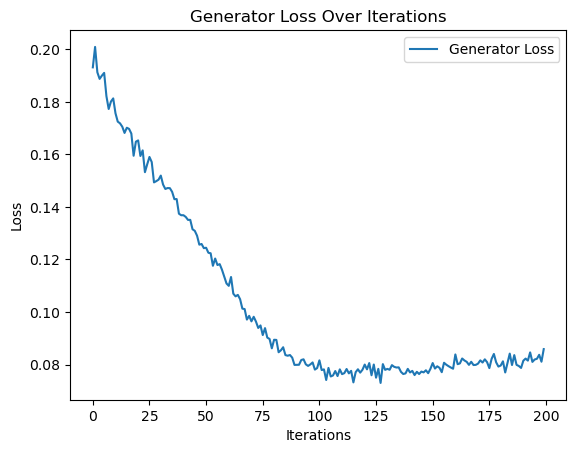

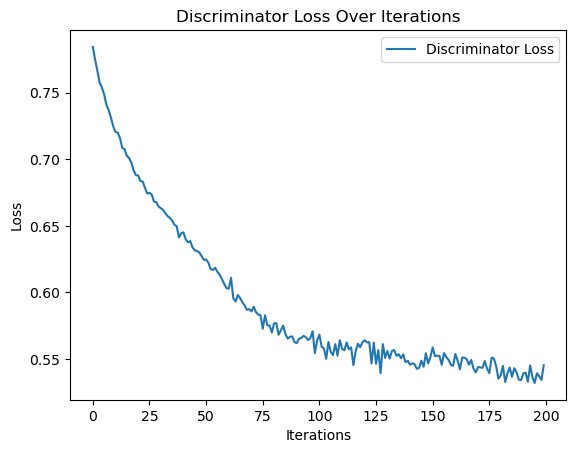

In [79]:
# Assuming `imputed_list`, `Gloss_list`, and `Dloss_list` are the outputs of the `gain` function

# To inspect the first imputation
#print("First Imputed Dataset:")
#print(imputed_list[0])

# To plot or analyze the loss values
import matplotlib.pyplot as plt

# Plot Generator Loss
plt.figure()
plt.plot(Gloss_list, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator Loss Over Iterations')
plt.legend()
plt.show()

# Plot Discriminator Loss
plt.figure()
plt.plot(Dloss_list, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Iterations')
plt.legend()
plt.show()

In [80]:
imputed_list[9].shape

(918, 11)

In [81]:
#imputed_df = imputed_data[9]
#assert imputed_df.shape[1] == data_del_new.shape[1], "Mismatch in number of columns"
data_imputed_GAIN = pd.DataFrame(imputed_data[9][9], columns=data_gain_new.columns)

In [82]:
data_imputed_GAIN.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,40.000000,137.681122,289.000000,0.0,172.0,0.00000,1.0,1.0,1.0,0.0,2.0
1,49.000000,122.036057,180.000000,0.0,156.0,0.58529,0.0,2.0,1.0,0.0,1.0
2,43.778591,130.000000,283.000000,0.0,98.0,0.00000,1.0,1.0,1.0,0.0,2.0
3,48.000000,138.000000,214.000000,0.0,108.0,1.50000,0.0,0.0,1.0,1.0,1.0
4,54.000000,150.000000,150.346939,0.0,122.0,0.00000,1.0,2.0,1.0,0.0,2.0


In [83]:
X = data_imputed_GAIN
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 42)

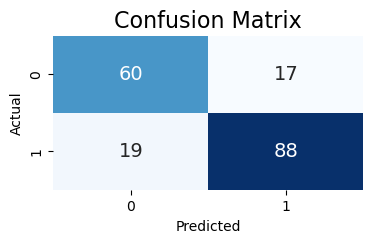

In [84]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cf_matrix_GAIN = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_GAIN, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_GAIN = accuracy_score(y_test,y_pred)
precision_GAIN = precision_score(y_test, y_pred)
recall_GAIN = recall_score(y_test, y_pred)
f1_GAIN = f1_score(y_test, y_pred)

In [85]:
print(f'Accuracy: {accuracy_GAIN:.4f}')
print(f'Precision: {precision_GAIN:.4f}')
print(f'Recall: {recall_GAIN:.4f}')
print(f'F1 Score: {f1_GAIN:.4f}')

Accuracy: 0.8043
Precision: 0.8381
Recall: 0.8224
F1 Score: 0.8302


## MIDA

In [86]:
from __future__ import division, print_function, absolute_import

In [87]:
def autoencoder_imputation(data_x, data_m, cat_index, num_index, all_levels, DAE_params, num_imputations):
    no, dim = data_x.shape
    # initial imputation
    data_x = initial_imputation(data_x, cat_index, num_index)

    data_train = np.array([])
    data_train_m = np.array([])
    ## encode cat
    if cat_index:
        data_cat = data_x[:, cat_index]
        data_cat_m = data_m[:, cat_index]
        data_cat_enc, data_cat_enc_miss = onehot_encoding(data_cat, data_cat_m, all_levels, has_miss=False)
        n_classes = list(map(lambda x: len(x), all_levels))
        data_train = data_cat_enc
        data_train_m = data_cat_enc_miss
    ## normalize num
    if num_index:
        data_num = data_x[:, num_index]
        data_num_m = data_m[:, num_index]
        data_num_norm, norm_parameters = normalization(data_num)
        data_train = np.concatenate([data_train, data_num_norm], axis=1) if data_train.size else data_num_norm
        data_train_m = np.concatenate([data_train_m, data_num_m], axis=1) if data_train_m.size else data_num_m

    # Training Parameters
    learning_rate = DAE_params["learning_rate"]
    num_steps1 = DAE_params["num_steps_phase1"]
    num_steps2 = DAE_params["num_steps_phase2"]
    batch_size = DAE_params["batch_size"]

    # Network Parameters
    num_input = data_train.shape[1]
    num_hidden_1 = data_train.shape[1] + DAE_params["theta"]  # 1st layer num features
    num_hidden_2 = data_train.shape[1] + 2 * DAE_params["theta"]  # 2nd layer num features (the latent dim)
    num_hidden_3 = data_train.shape[1] + 3 * DAE_params["theta"]

    # A random value generator to initialize weights.
    random_normal = tf.initializers.RandomNormal()

    weights = {
        'encoder_h1': tf.Variable(random_normal([num_input, num_hidden_1])),
        'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
        'encoder_h3': tf.Variable(random_normal([num_hidden_2, num_hidden_3])),
        'decoder_h1': tf.Variable(random_normal([num_hidden_3, num_hidden_2])),
        'decoder_h2': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
        'decoder_h3': tf.Variable(random_normal([num_hidden_1, num_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
        'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
        'encoder_b3': tf.Variable(random_normal([num_hidden_3])),
        'decoder_b1': tf.Variable(random_normal([num_hidden_2])),
        'decoder_b2': tf.Variable(random_normal([num_hidden_1])),
        'decoder_b3': tf.Variable(random_normal([num_input])),
    }

    # Building the encoder
    @tf.function
    def encoder(x):
        x_noise = tf.nn.dropout(x, 0.5)
        layer_1 = tf.nn.tanh(tf.add(tf.matmul(x_noise, weights['encoder_h1']),
                                       biases['encoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                       biases['encoder_b2']))
        layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                       biases['encoder_b3']))
        return layer_3

    # Building the decoder
    @tf.function
    def decoder(x):
        layer_1 = tf.nn.tanh(tf. add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        layer_3 = tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                         biases['decoder_b3'])
        col_index = 0
        empty_G_out = True
        # apply softmax to each categorical variable
        if cat_index:
            empty_G_out = False
            output = tf.nn.softmax(layer_3[:, :n_classes[0]])
            col_index = n_classes[0]
            for j in range(1, len(n_classes)):
                output = tf.concat(values=[output, tf.nn.softmax(layer_3[:, col_index:col_index + n_classes[j]])], axis=1)
                col_index += n_classes[j]
        # apply sigmoid to all numerical variables
        if num_index:
            out_num = tf.nn.sigmoid(layer_3[:, col_index:])
            output = tf.concat(values=[output, out_num], axis=1) if not empty_G_out else out_num
        return output

    # sum up loss for each categorical variable
    @tf.function
    def dae_loss(y_pred, y_true, mask):
        loss = 0
        current_ind = 0
        # categorical loss
        if cat_index:
            for j in range(len(n_classes)):
                mask_current = mask[:, current_ind:current_ind + n_classes[j]]
                y_pred_current = y_pred[:, current_ind:current_ind + n_classes[j]]
                y_true_current = y_true[:, current_ind:current_ind + n_classes[j]]
                loss += -tf.reduce_mean(
                    input_tensor=mask_current * y_true_current * tf.math.log(mask_current * y_pred_current + 1e-8)) / tf.reduce_mean(
                    input_tensor=mask_current)
                current_ind += n_classes[j]
        # numerical loss
        if num_index:
            mask_current = mask[:, current_ind:]
            y_pred_current = y_pred[:, current_ind:]
            y_true_current = y_true[:, current_ind:]
            loss += tf.reduce_mean((mask_current * y_true_current - mask_current * y_pred_current)**2) / tf.reduce_mean(mask_current)
        return loss

    # optimizer
    @tf.function
    def optimize_step(batch_x, batch_m):
        with tf.GradientTape() as g:
            y_hat = decoder(encoder(batch_x))
            l = dae_loss(y_hat, batch_x, batch_m)

        trainable_variables = list(weights.values()) + list(biases.values())

        gradients = g.gradient(l, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return l, y_hat

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate, decay=0.0)

    # multiple imputation
    imputed_list = []
    for l in range(num_imputations):
        # Start Training
        # Training phase 1
        loss_list = []
        pbar = tqdm(range(num_steps1))
        for i in pbar:
            # create mini batch
            indices = np.arange(no)
            np.random.shuffle(indices)
            for start_idx in range(0, no - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                batch_x = data_train[batch_idx, :]
                batch_m = data_train_m[batch_idx, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                l, y_hat = optimize_step(batch_x, batch_m)
                pbar.set_description("loss at epoch {}: {:.3f}, phase 1".format(i, l))
                loss_list.append(l)

        imputed_data = decoder(encoder(data_train))
        imputed_data = data_train_m * data_train + (1 - data_train_m) * imputed_data

        # Training phase 2
        pbar = tqdm(range(num_steps2))
        for i in pbar:
            # create mini batch
            indices = np.arange(no)
            np.random.shuffle(indices)
            for start_idx in range(0, no - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                batch_x = tf.gather(imputed_data, batch_idx, axis=0)
                batch_m = data_train_m[batch_idx, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                l, y_hat = optimize_step(batch_x, batch_m)
                pbar.set_description("loss at epoch {}, phase 2: {:.3f}".format(i, l))
                loss_list.append(l)

        # get imputation
        imputed_data = decoder(encoder(imputed_data))
        imputed_data = data_train_m * data_train + (1 - data_train_m) * imputed_data

        # revert onehot and renormalize
        imputed = np.empty(shape=(no, dim))
        if cat_index:
            imputed_cat = imputed_data[:, :data_cat_enc.shape[1]]
            imputed_cat = onehot_decoding(imputed_cat, data_cat_enc_miss, all_levels, has_miss=False)
            imputed[:, cat_index] = imputed_cat
        if num_index:
            imputed_num = imputed_data[:, -data_num.shape[1]:]
            imputed_num = renormalization(imputed_num.numpy(), norm_parameters)
            imputed[:, num_index] = imputed_num
        imputed_list.append(imputed)
    return imputed_list, loss_list

In [88]:
data_mida = data_MNAR_df.copy()
cat_cols=  ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
num_cols = [ 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
data_mida_new = data_mida[num_cols]
data_mida_new = pd.concat([data_mida_new, data_mida[cat_cols]],axis = 1)

In [89]:
DAE_parameters = {'learning_rate': 0.001,
                        'batch_size': 512,
                        'num_steps_phase1': 200,
                        'num_steps_phase2': 2,
                        'theta': 7}
num_index = list(range(0,6))
cat_index = list(range(6,11))

In [90]:
# Convert DataFrame to NumPy array
data_x = data_mida_new.values.astype(np.float32)
data_m = 1 - data_mida_new.isna().astype(np.float32).values

 # get all possible levels for categorical variable
all_levels = [np.unique(x) for x in data_x[:, cat_index].T]
all_levels_dict = dict(zip(data_mida_new.columns[cat_index], all_levels))

In [91]:
rmse_ls = []
num_samples = 10
num_imputations = 10
imputed_data = {i: [] for i in range(num_samples)}

In [92]:
for i in range(num_samples):
    # Assuming data_x already has missing values
    miss_data_x = data_x.copy()
    data_m = 1 - np.isnan(miss_data_x).astype(np.float32)  # Mask for missing values

    # Initial imputation (e.g., using mean imputation)
    initial_imputated_data = np.nan_to_num(miss_data_x, nan=np.nanmean(miss_data_x, axis=0))

    # Perform the imputation using the model
    #if model_name == "mida":
    imputed_list, loss_list = autoencoder_imputation(initial_imputated_data, data_m, cat_index, num_index,
                                                           all_levels, DAE_parameters, num_imputations)
    
    #imputed_list, Gloss_list, Dloss_list = gain(initial_imputation, data_m, cat_index, num_index,
    #                                            all_levels, gain_parameters, num_imputations)

    # Store the imputed data in memory
    for l in range(num_imputations):
        imputed_data[i].append(imputed_list[l])

    print("{} done!".format(i))

# Example: Accessing the imputed data for the first sample
#print(imputed_data[0])

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
loss at epoch 1, phase 2: 0.613: 100%|███████████| 2/2 [00:00<00:00, 350.39it/s]


0 done!


loss at epoch 1, phase 2: 0.611: 100%|███████████| 2/2 [00:00<00:00, 377.22it/s]


1 done!


loss at epoch 1, phase 2: 0.604: 100%|███████████| 2/2 [00:00<00:00, 415.01it/s]


2 done!


loss at epoch 1, phase 2: 0.619: 100%|███████████| 2/2 [00:00<00:00, 391.68it/s]


3 done!


loss at epoch 1, phase 2: 0.607: 100%|███████████| 2/2 [00:00<00:00, 349.09it/s]


4 done!


loss at epoch 1, phase 2: 0.576: 100%|███████████| 2/2 [00:00<00:00, 365.36it/s]


5 done!


loss at epoch 1, phase 2: 0.582: 100%|███████████| 2/2 [00:00<00:00, 366.63it/s]


6 done!


loss at epoch 1, phase 2: 0.601: 100%|███████████| 2/2 [00:00<00:00, 367.24it/s]


7 done!


loss at epoch 1, phase 2: 0.587: 100%|███████████| 2/2 [00:00<00:00, 384.16it/s]


8 done!


loss at epoch 1, phase 2: 0.551: 100%|███████████| 2/2 [00:00<00:00, 382.85it/s]


9 done!


In [93]:
data_imputed_mida = pd.DataFrame(imputed_data[9][9], columns=data_mida_new.columns)

In [94]:
X = data_imputed_mida
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 42)

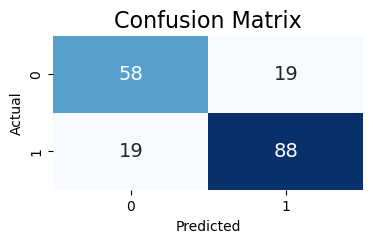

In [95]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cf_matrix_MIDA = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_MIDA, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_MIDA = accuracy_score(y_test,y_pred)
precision_MIDA = precision_score(y_test, y_pred)
recall_MIDA = recall_score(y_test, y_pred)
f1_MIDA = f1_score(y_test, y_pred)

In [96]:
print(f'Accuracy: {accuracy_MIDA:.4f}')
print(f'Precision: {precision_MIDA:.4f}')
print(f'Recall: {recall_MIDA:.4f}')
print(f'F1 Score: {f1_MIDA:.4f}')

Accuracy: 0.7935
Precision: 0.8224
Recall: 0.8224
F1 Score: 0.8224


# K-means imputation

In [97]:
data_MNAR_Kmeans = data_MNAR_df.copy()

In [98]:
imputer = SimpleImputer(strategy='mean')
X = data_MNAR_Kmeans
y = target


data_imputed_Kmeans = imputer.fit_transform(X)

In [99]:
# Number of clusters
k = 3
num_iterations = 10

for _ in range(num_iterations):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(data_imputed_Kmeans)

    # Impute missing values based on cluster means
    for cluster in range(k):
        cluster_indices = np.where(clusters == cluster)
        cluster_data = data_imputed_Kmeans[cluster_indices]

        # Calculate mean of each feature in the cluster
        cluster_means = np.nanmean(cluster_data, axis=0)

        # Impute missing values in the original data
        for i in cluster_indices[0]:
            for j in range(data_imputed_Kmeans.shape[1]):
                # Check if the original data had a missing value
                if np.isnan(X.iloc[i, j]):  # Correctly access the DataFrame
                    data_imputed_Kmeans[i, j] = cluster_means[j]

# After imputation, you can reattach the target variable
data_imputed_Kmeans_df = pd.DataFrame(data_imputed_Kmeans, columns=X.columns)
#data_imputed_Kmeans_df['HeartDisease'] = y


/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

In [100]:
X = data_imputed_Kmeans_df
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.80,random_state = 42)

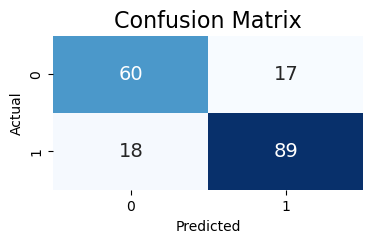

In [101]:
model = RandomForestClassifier(n_estimators=200,random_state = 42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cf_matrix_kmeans_impute = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using seaborn for a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cf_matrix_kmeans_impute, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

accuracy_kmeans_impute = accuracy_score(y_test,y_pred)
precision_kmeans_impute = precision_score(y_test, y_pred)
recall_kmeans_impute = recall_score(y_test, y_pred)
f1_kmeans_impute = f1_score(y_test, y_pred)

In [102]:
print(f'Accuracy: {accuracy_kmeans_impute:.4f}')
print(f'Precision: {precision_kmeans_impute:.4f}')
print(f'Recall: {recall_kmeans_impute:.4f}')
print(f'F1 Score: {f1_kmeans_impute:.4f}')

Accuracy: 0.8098
Precision: 0.8396
Recall: 0.8318
F1 Score: 0.8357
